In [1]:
import pandas as pd
import os, sys
project_root = os.path.abspath("../")
sys.path.append(project_root)
print("Added path:", project_root)

Added path: /Users/hippolyteheger/code/ArnaudThs/StockProphet/StockProphet


In [2]:
from Project.param import *
from Project.data import *
from Project.sentiment_analysis import *
from Project.model import *

In [3]:
from Project.main import *
print("main.py imports successfully!")

main.py imports successfully!


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [4]:
pip install gymnasium stable-baselines3 pandas numpy tensorflow shimmy

Note: you may need to restart the kernel to use updated packages.


/Users/hippolyteheger/code/ArnaudThs/StockProphet/StockProphet/Project/data.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)


--- Starting Trading Bot Pipeline ---
Loading data for AAPL...


[*********************100%***********************]  1 of 1 completed


Running RNN Analysis...
Loading existing LSTM predictor...
Generating predictions...
Merging Data...
Train Size: 1063, Test Size: 266
Training PPO Agent...
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2546 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1984        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009686516 |
|    clip_fraction        | 0.0337      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0054     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.254       |
|    n_updates            | 1

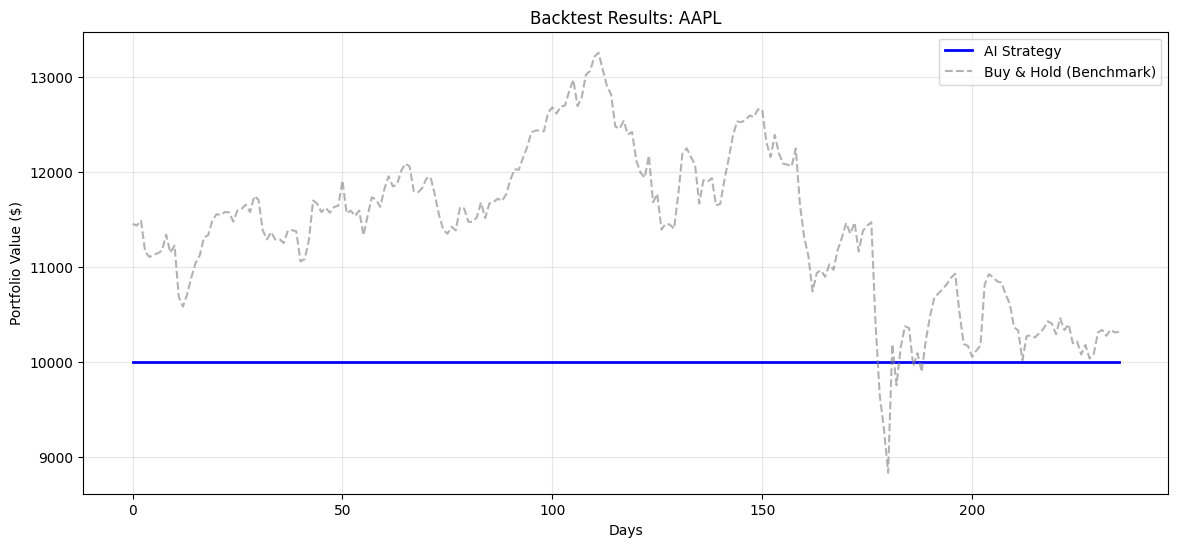

Done.


In [4]:
main()

In [ ]:
df_ohlcv = load_market_data(TICKER)
df_local = df_ohlcv.rename(columns={"date": "Date"})[["Date", "close"]].copy()
df_ohlcv.head()

/Users/hippolyteheger/code/ArnaudThs/StockProphet/StockProphet/Project/data.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


,date,close,high,low,open,volume
0,2020-01-02,72.468269,72.528589,71.223267,71.476607,135480400
1,2020-01-03,71.763695,72.523723,71.539307,71.696137,146322800
2,2020-01-06,72.335579,72.374185,70.634562,70.885494,118387200
3,2020-01-07,71.995361,72.600968,71.775796,72.345212,108872000
4,2020-01-08,73.153503,73.455103,71.698589,71.698589,132079200


In [ ]:
df = load_data(ticker = TICKER, start_date = START_DATE, end_date = END_DATE)
df

/Users/hippolyteheger/code/ArnaudThs/StockProphet/StockProphet/Project/data.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume
0,2020-01-02,72.468269,72.528589,71.223267,71.476607,135480400
1,2020-01-03,71.763695,72.523723,71.539307,71.696137,146322800
2,2020-01-06,72.335579,72.374185,70.634562,70.885494,118387200
3,2020-01-07,71.995361,72.600968,71.775796,72.345212,108872000
4,2020-01-08,73.153503,73.455103,71.698589,71.698589,132079200
...,...,...,...,...,...,...
1374,2025-06-23,201.076660,201.874982,198.542003,201.206392,55814300
1375,2025-06-24,199.879181,203.012583,199.779385,202.164363,54064000
1376,2025-06-25,201.136536,203.242103,200.198508,201.026766,39525700
1377,2025-06-26,200.577698,202.214251,199.040940,201.006787,50799100


In [ ]:
WINDOW_SIZE = 50
TRAIN_RATIO = 0.8
BATCH_SIZE = 32
LSTM_EPOCHS = 10
RNN_MODEL_SAVE = "lstm_rnn.keras"


In [ ]:
# -------------------------
# Utility: Build RNN predictions aligned to dates
# -------------------------
def build_rnn_predictions(df_ohlc: pd.DataFrame, window_size: int = WINDOW_SIZE,
                          epochs: int = LSTM_EPOCHS, batch_size: int = BATCH_SIZE,
                          force_retrain: bool = True) -> pd.Series:
    """
    Train LSTM on historical Close and produce a one-day-ahead prediction for each day
    where enough history exists. Returns a pd.Series indexed by date with predicted value
    in the same scale as the original Close (not scaled).
    """
    df_local = df_ohlc.copy()

    # Normalize date column name
    if "date" in df_local.columns:
        df_local = df_local.rename(columns={"date": "Date"})
    elif "Date" not in df_local.columns:
        raise ValueError("DataFrame must contain either 'Date' or 'date' column.")

    df_local = df_local[["Date", "Close"]].reset_index(drop=True)
    # Use the helper which returns X_train,y_train,X_test,y_test,scaler
    X_train, y_train, X_test, y_test, scaler = train_test_split_lstm(df_local)

    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])  # (seq_len, n_features)
    model = LSTM_model(input_shape)
    model = compile_LSTM(model)

    # Train model (if force_retrain or no saved model)
    if force_retrain or not os.path.exists(RNN_MODEL_SAVE):
        print("Training LSTM predictor...")
        train_LSTM(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
        model.save(RNN_MODEL_SAVE)
    else:
        print("Loading existing LSTM predictor...")
        from keras.models import load_model
        model = load_model(RNN_MODEL_SAVE)

    # Now generate sliding-window predictions across the full dataset
    closes = df_local["Close"].values.reshape(-1, 1)
    closes_scaled = scaler.transform(closes)  # use same scaler

    preds = []
    dates = []
    for end_idx in range(window_size, len(closes_scaled)):
        start_idx = end_idx - window_size
        seq = closes_scaled[start_idx:end_idx]  # shape (window_size, 1)
        seq = seq.reshape((1, seq.shape[0], seq.shape[1]))
        pred_scaled = model.predict(seq, verbose=0)
        pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0, 0]
        preds.append(pred)
        dates.append(df_local.loc[end_idx, "Date"])  # prediction aligned to day end_idx

    preds_series = pd.Series(data=preds, index=pd.to_datetime(dates))
    preds_series.name = "rnn_pred_close"
    return preds_series


# -------------------------
# Utility: Merge OHLC / Sentiment / RNN preds and create lag-features
# -------------------------
def build_merged_dataframe(df_ohlc: pd.DataFrame, df_sentiment: pd.DataFrame,
                           rnn_preds: pd.Series, window_size: int = WINDOW_SIZE) -> pd.DataFrame:
    """
    Returns DataFrame with columns:
    Date, Open, High, Low, Close, Volume, sentiment, rnn_pred_close,
    close_lag_1 .. close_lag_{window_size}, next_return (reward target).
    """
    # Normalize column names & Date
    df = df_ohlc.copy()
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").sort_index()

    # Merge sentiment (df_sentiment is indexed by date)
    df_sent = df_sentiment.copy()
    if "date" in df_sent.columns or df_sent.index.name == "date":
        df_sent.index = pd.to_datetime(df_sent.index)
    df_sent = df_sent.rename(columns={df_sent.columns[0]: "sentiment"})
    df = df.join(df_sent, how="left")
    df["sentiment"] = df["sentiment"].fillna(0.0)

    # Merge RNN preds (already indexed by date)
    df = df.join(rnn_preds.rename("rnn_pred_close"), how="left")

    # compute returns (next day) for reward and intraday if needed
    df["close"] = df["Close"].astype(float)
    df["return"] = df["close"].pct_change()
    # next day return as target (reward reference)
    df["next_return"] = df["return"].shift(-1)

    # Create lag features for close (flattened)
    for i in range(1, window_size + 1):
        df[f"close_lag_{i}"] = df["close"].shift(i)

    # drop rows without enough history or without next_return
    df = df.dropna().reset_index()
    return df

In [ ]:
series = build_rnn_predictions(df_ohlc=df_ohlcv)

Training LSTM predictor...
Epoch 1/20


/Users/hippolyteheger/.pyenv/versions/3.10.6/envs/StockProphet/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0022 - loss: 0.0374  
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0022 - loss: 0.0033
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0022 - loss: 0.0019    
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0022 - loss: 0.0017
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0022 - loss: 0.0018  
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0022 - loss: 0.0016
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0022 - loss: 0.0015
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0022 - loss: 0.0016
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0022 - loss: 0.0016    
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0022 - loss: 0.0015
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0022 - loss: 0.0014
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy

In [ ]:
series

2020-03-16     70.116516
2020-03-17     69.230682
2020-03-18     68.324776
2020-03-19     67.381516
2020-03-20     66.440697
                 ...    
2025-06-23    194.981354
2025-06-24    194.927063
2025-06-25    194.953796
2025-06-26    195.107971
2025-06-27    195.303665
Name: rnn_pred_close, Length: 1329, dtype: float32

In [ ]:
df_daily = fetch_daily_ticker_sentiment(api_key = API_KEY_MASSIVE, ticker = SENTIMENT_TICKERS, start_date = SENTIMENT_START_DATE, end_date = SENTIMENT_END_DATE)

In [ ]:
df = build_merged_dataframe(df_ohlc = df_ohlcv, df_sentiment=df_daily,
                           rnn_preds = series, window_size = 50)

In [ ]:
df

,date,Close,High,Low,Open,Volume,sentiment,rnn_pred_close,close,return,...,close_lag_41,close_lag_42,close_lag_43,close_lag_44,close_lag_45,close_lag_46,close_lag_47,close_lag_48,close_lag_49,close_lag_50
0,2020-03-16,58.578979,62.659018,58.044485,58.516096,322423600,0.0,70.116516,58.578979,-0.128647,...,75.119934,75.443237,76.475914,74.876221,74.707329,73.153473,71.995354,72.335533,71.763725,72.468262
1,2020-03-17,61.154697,62.303491,57.657516,59.860788,324056000,0.0,69.230682,61.154697,0.043970,...,76.060921,75.119934,75.443237,76.475914,74.876221,74.707329,73.153473,71.995354,72.335533,71.763725
2,2020-03-18,59.657642,60.463010,57.347955,57.988865,300233600,0.0,68.324776,59.657642,-0.024480,...,76.902977,76.060921,75.119934,75.443237,76.475914,74.876221,74.707329,73.153473,71.995354,72.335533
3,2020-03-19,59.200535,61.149861,58.675716,59.831769,271857200,0.0,67.381516,59.200535,-0.007662,...,76.381805,76.902977,76.060921,75.119934,75.443237,76.475914,74.876221,74.707329,73.153473,71.995354
4,2020-03-20,55.442165,60.905602,55.142268,59.780988,401693200,0.0,66.440697,55.442165,-0.063485,...,76.654480,76.381805,76.902977,76.060921,75.119934,75.443237,76.475914,74.876221,74.707329,73.153473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,2025-06-20,200.577713,201.276239,196.446411,197.823517,96813500,1.0,195.242447,200.577713,0.022485,...,199.059326,192.501724,196.308716,193.607956,201.451126,201.829849,197.474731,189.771072,198.172348,171.832428
1324,2025-06-23,201.076645,201.874967,198.541988,201.206377,55814300,2.0,194.981354,201.076645,0.002487,...,203.902740,199.059326,192.501724,196.308716,193.607956,201.451126,201.829849,197.474731,189.771072,198.172348
1325,2025-06-24,199.879181,203.012583,199.779385,202.164363,54064000,0.0,194.927063,199.879181,-0.005955,...,207.659912,203.902740,199.059326,192.501724,196.308716,193.607956,201.451126,201.829849,197.474731,189.771072
1326,2025-06-25,201.136520,203.242088,200.198493,201.026751,39525700,-1.0,194.953796,201.136520,0.006290,...,208.566803,207.659912,203.902740,199.059326,192.501724,196.308716,193.607956,201.451126,201.829849,197.474731


In [ ]:
from Project.main import main

main()  # will execute the full pipeline


/Users/hippolyteheger/code/ArnaudThs/StockProphet/StockProphet/Project/data.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Loading OHLC data...
Computing RNN predictions...
Training LSTM predictor...
Epoch 1/20



/Users/hippolyteheger/.pyenv/versions/3.10.6/envs/StockProphet/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0022 - loss: 0.0521
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0022 - loss: 0.0040
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0022 - loss: 0.0021    
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0022 - loss: 0.0017    
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0022 - loss: 0.0016    
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0022 - loss: 0.0017 
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0022 - loss: 0.0016
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0022 - loss: 0.0015
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0022 - loss: 0.0015
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0022 - loss: 0.0014   
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0022 - loss: 0.0015
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accu

In [ ]:
# main.py
import os
import numpy as np
import pandas as pd
from datetime import datetime
from typing import Tuple

# your modules
from Project.data import load_data, train_test_split_lstm
from Project.model import LSTM_model, compile_LSTM, train_LSTM, test_lstm_model
from Project.sentiment_analysis import fetch_daily_ticker_sentiment
from Project.param import *

# RL imports
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

WINDOW_SIZE = 50
TRAIN_RATIO = 0.8
BATCH_SIZE = 32
LSTM_EPOCHS = 10
PPO_TIMESTEPS = 50_000  # reduce for quick tests
MODEL_SAVE_PATH = "ppo_trader.zip"
RNN_MODEL_SAVE = "lstm_rnn.keras"
TRANSACTION_COST_PCT = 0.0005



import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd



class TradingEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, df: pd.DataFrame, window_size: int = 30):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.initial_cash = 10_000
        self.cash = self.initial_cash
        self.shares = 0
        self.current_step = window_size

        self.feature_columns = [
            "close",
            "sentiment",
            "rnn_pred_close",
        ] + [c for c in df.columns if c.startswith("close_lag_")]

        self.num_features = len(self.feature_columns)
        obs_size = self.window_size * self.num_features + 2

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

        # track history for plotting
        self.portfolio_history = []
        self.action_history = []
        self.reward_history = []

    def _get_observation(self):
        start = self.current_step - self.window_size
        end = self.current_step
        window = self.df.loc[start:end - 1, self.feature_columns].values
        obs = np.concatenate([window.flatten(), np.array([self.cash, self.shares], dtype=np.float32)])
        return obs.astype(np.float32)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.cash = self.initial_cash
        self.shares = 0
        self.current_step = self.window_size
        self.portfolio_history = []
        self.action_history = []
        self.reward_history = []
        return self._get_observation(), {}

    def step(self, action):
        price = self.df.loc[self.current_step, "close"]

        # BUY
        if action == 1 and self.cash >= price:
            cost = price * (1 + TRANSACTION_COST_PCT)
            if self.cash >= cost:
                self.cash -= cost
                self.shares += 1

        # SELL
        elif action == 2 and self.shares > 0:
            proceeds = price * (1 - TRANSACTION_COST_PCT)
            self.cash += proceeds
            self.shares -= 1

        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        truncated = False

        # reward = portfolio value
        portfolio_value = self.cash + self.shares * self.df.loc[self.current_step, "close"]
        reward = portfolio_value - (self.portfolio_history[-1] if self.portfolio_history else self.initial_cash)

        # store for plotting
        self.portfolio_history.append(portfolio_value)
        self.action_history.append(action)
        self.reward_history.append(reward)

        return self._get_observation(), reward, terminated, truncated, {}

    def render(self):
        print(f"Step {self.current_step} | Cash: {self.cash:.2f} | Shares: {self.shares} | Portfolio: {self.cash + self.shares * self.df.loc[self.current_step, 'close']:.2f}")


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv


def train_ppo_on_df(df, timesteps=5000):
    env = DummyVecEnv([lambda: TradingEnv(df, window_size=30)])
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=timesteps)
    model.save("ppo_trading_model")
    return model


In [ ]:
def test_and_plot(df, model_path="ppo_trading_model.zip"):
    from matplotlib import pyplot as plt

    model = PPO.load(model_path)
    env = TradingEnv(df)
    obs, _ = env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            done = True

    # Plot portfolio
    plt.figure(figsize=(14,5))
    plt.plot(env.portfolio_history, label="Portfolio Value")
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Step")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot rewards
    plt.figure(figsize=(14,5))
    plt.plot(env.reward_history, label="Reward per step")
    plt.title("Reward Over Time")
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot actions overlay on price
    plt.figure(figsize=(14,5))
    plt.plot(df["close"].values[env.window_size:], label="Price")
    actions = np.array(env.action_history)
    buys = np.where(actions==1)[0]
    sells = np.where(actions==2)[0]
    plt.scatter(buys, df["close"].values[env.window_size:][buys], marker="^", color="g", label="Buy")
    plt.scatter(sells, df["close"].values[env.window_size:][sells], marker="v", color="r", label="Sell")
    plt.title("Price with Buy/Sell Actions")
    plt.xlabel("Step")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
pip install "shimmy>=2.0"

Note: you may need to restart the kernel to use updated packages.


In [ ]:
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size].reset_index(drop=True)
df_test  = df.iloc[train_size:].reset_index(drop=True)
model = train_ppo_on_df(df_train)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2192 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1494        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010811789 |
|    clip_fraction        | 0.0451      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.000418   |
|    learning_rate        | 0.0003      |
|    loss                 | 4.18e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00186    |
|    value_loss           | 7.18e+03    |
-----------------------------------------
-----------------

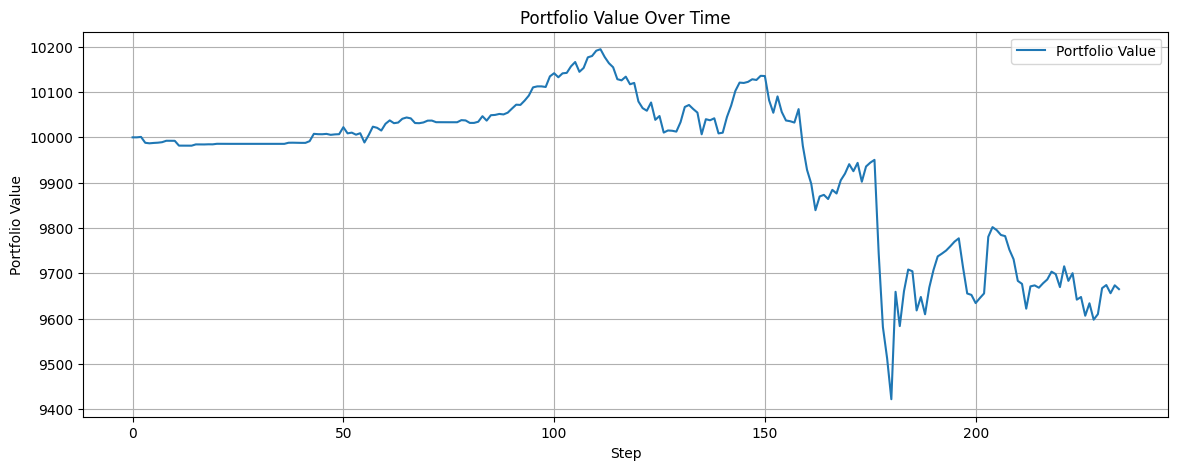

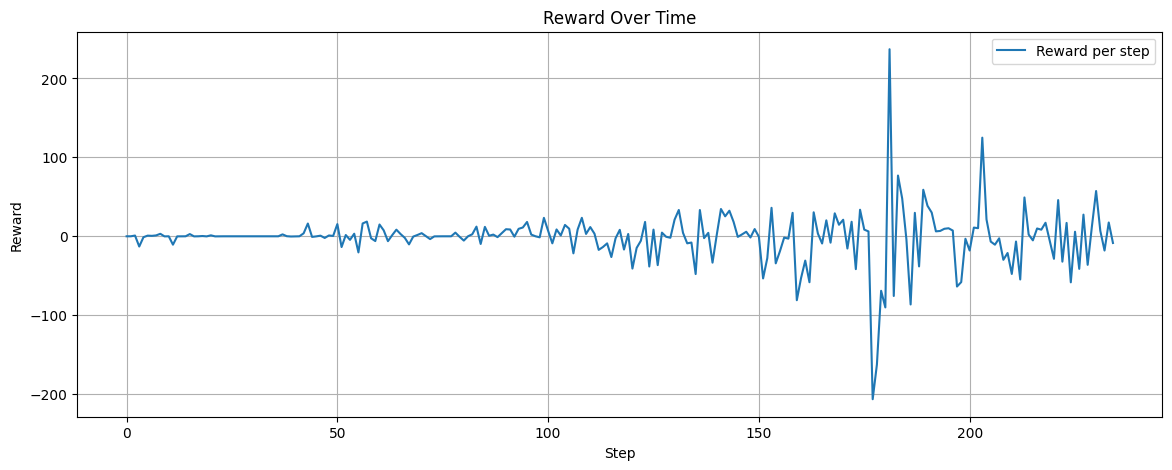

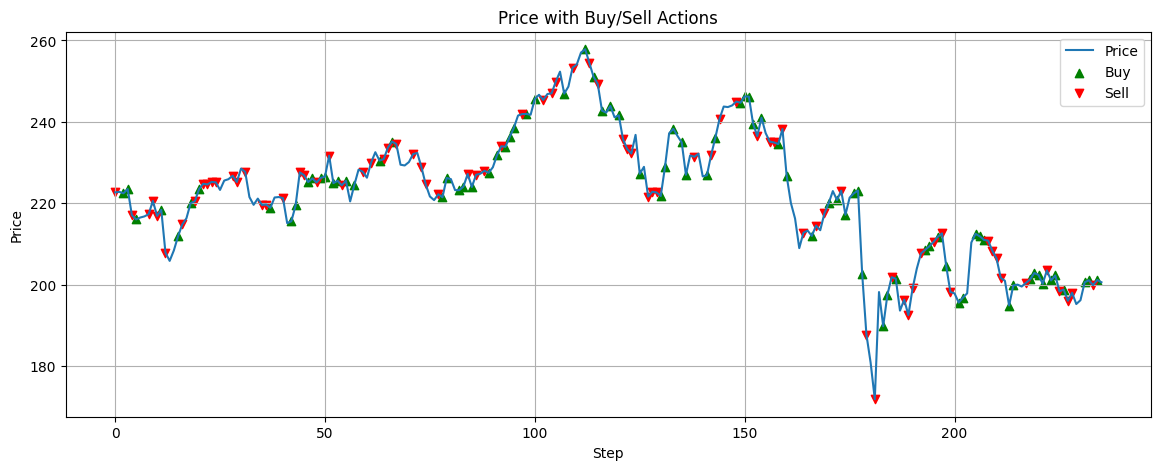

In [ ]:
test_and_plot(df_test)

In [ ]:
q